In [ ]:
"""
Team: Angboolers (Kaggle)
Team Members: Massimiliano Sica (TL), Persona code: 10558133
              Marco Labate, Persona code: 10491539
              Arnab Mondal, Persona code: 10714338
      
Dataset: Artificial Neural Networks and Deep Learning 2020, homework 1: Image classification.
Dataset description: 5614 training examples, 450 test examples. 


In [ ]:
#Importing all the necessary libraries for our code.

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import tensorflow as tf 
import os 
import numpy as np  
from google.colab import drive
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
from keras.applications.vgg16 import preprocess_input 
import sys
import os
from keras.layers import *
from keras.optimizers import *
from keras.applications import *
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping

import pandas as pd
import json
import sklearn

In [ ]:
SEED= 10714338 # fix seed for reproducible results (only works on CPU, not GPU)
tf.random.set_seed(SEED)

cwd= os.getcwd() #get current working directory 

In [ ]:
drive.mount('/content/drive') #mounting google drive for data I/O

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#declaring the most necessary variables
num_classes=3 # number of classes to classify
batch_size = 16 #our batch size
learn_rate = 1e-4 #learning rate

img_h=224 #our image height for resizing
img_w=224 #our image width for resizing


In [ ]:
# Read Data and Augment it: This data augmentation is going to modify the training samples every epoch. It is provided to create more training samples and 
# enhance our validation set accuracy
apply_data_augmentation  = True

if  apply_data_augmentation:
  train_datagen = ImageDataGenerator(             
  width_shift_range = 0.2, 
  height_shift_range = 0.2,
  vertical_flip=True,
  shear_range = 0.2,
  horizontal_flip=True,
  rotation_range=10,
  fill_mode='constant',
  cval=0,
  rescale=1/255,   
  preprocessing_function=preprocess_input)
  
else:
  train_datagen = ImageDataGenerator(rescale=1/255,
                                     preprocessing_function=preprocess_input)

valid_datagen = ImageDataGenerator(rescale=1/255,
                                   preprocessing_function=preprocess_input)
test_datagen= ImageDataGenerator(rescale=1/255,
                                 preprocessing_function=preprocess_input)


In [ ]:
# Here we added labels to our training samples to create the ground truth, the labels were written in a json file


json_path=os.path.join(cwd,'drive','My Drive','AN2DL_HW_1','MaskDataset')        #getting the directory where train_gt.json file is present

with open(os.path.join(json_path,"train_gt.json")) as j:
  tmp = json.load(j)

train_df = pd.DataFrame(tmp.items())
train_df.rename(columns = {0:'filename', 1:'class'}, inplace = True)
train_df["class"] = train_df["class"].astype(str)

train_df_shuffled=sklearn.utils.shuffle(train_df)                                #here we could divide the dataset in training and validation

training_df= train_df_shuffled[:3913]                                            #creating a training and validation set at a 70:30 ratio, we found it to be optimum
validation_df= train_df_shuffled[3913:]

#print(validation_df,training_df)                                                Uncomment to view the filenames and their respective classes.

       filename class
3174  14235.jpg     1
3226  10369.jpg     1
3676  14447.jpg     1
3009  10387.jpg     1
4392  16320.jpg     2
...         ...   ...
810   13750.jpg     0
2418  17534.jpg     1
274   14738.jpg     0
943   16007.jpg     0
3205  10532.jpg     1

[1701 rows x 2 columns]        filename class
4544  11297.jpg     2
4731  10147.jpg     2
3321  14919.jpg     1
451   13909.jpg     0
1775  15396.jpg     0
...         ...   ...
1277  10340.jpg     0
1907  15968.jpg     1
2488  14759.jpg     1
4112  13181.jpg     2
4579  16821.jpg     2

[3913 rows x 2 columns]


In [ ]:
#Let's create the generators 

directory_training =os.path.join(cwd,'drive','My Drive','AN2DL_HW_1','MaskDataset','training')


bs = batch_size

train_generator=train_datagen.flow_from_dataframe(
dataframe=training_df,
directory=directory_training,
x_col="filename",
y_col="class",
batch_size=bs,
seed=SEED,

shuffle=True,
target_size=(224, 224),
class_mode="categorical",
)

valid_generator=valid_datagen.flow_from_dataframe(
dataframe=validation_df,
directory=directory_training,
x_col="filename",
y_col="class",
batch_size=bs,
seed=SEED,
shuffle=True,
target_size=(224, 224),
class_mode="categorical",
)

Found 3913 validated image filenames belonging to 3 classes.
Found 1701 validated image filenames belonging to 3 classes.


In [ ]:
#creating the training and validation datasets
train_dataset= tf.data.Dataset.from_generator(lambda:train_generator,
                                              (tf.float32, tf.float32),
                                              ([None,img_h,img_w,3],[None,num_classes])) 

train_dataset=train_dataset.repeat()

validation_dataset= tf.data.Dataset.from_generator(lambda:valid_generator,
                                              (tf.float32, tf.float32),
                                              ([None,img_h,img_w,3],[None,num_classes]))


validation_dataset=validation_dataset.repeat()


[]

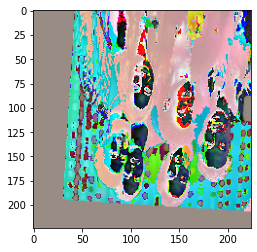

In [ ]:
#plotting the pictures
import matplotlib.pyplot as plt
%matplotlib inline

iterator= iter(train_dataset)

img , target = next(iterator)

img= np.array(img[0])
img=img *255
plt.imshow(np.uint8(img))
plt.plot()

[]

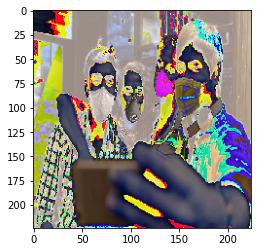

In [ ]:
#plotting the pictures
%matplotlib inline

iterator= iter(validation_dataset)

img , target = next(iterator)

img= np.array(img[0])
img=img *255
plt.imshow(np.uint8(img))
plt.plot()

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers
DenseNet_model = tf.keras.applications.DenseNet121(weights='imagenet', include_top=False, input_shape=(224,224,3))
x = tf.keras.layers.AveragePooling2D(pool_size=(3,3), name='avg_pool')(DenseNet_model.output)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(1024, activation='relu', name='dense_post_pool')(x)
x = tf.keras.layers.Dropout(0.5)(x)
output = tf.keras.layers.Dense(3, activation='softmax', name='predictions')(x)

model = Model(DenseNet_model.input, output)
#model.summary()                                                                 Uncomment to view the model summary

In [ ]:
loss= tf.keras.losses.CategoricalCrossentropy()

lr= learn_rate

optimizer= tf.keras.optimizers.RMSprop(learning_rate=lr)

metrics=['accuracy']

model.compile(optimizer=optimizer,loss=loss,metrics=metrics )

In [ ]:
#lets do early stopping callback 


callbacks=[]

es_callback= tf.keras.callbacks.EarlyStopping(monitor='val_loss',restore_best_weights=True,patience = 5) 
callbacks.append(es_callback)
    
test_dir =os.path.join(cwd,'drive','My Drive')



model.fit(x=train_dataset, 
          epochs=10,  #max number of epoch 
          steps_per_epoch=len(train_generator),
          validation_data= validation_dataset, 
          validation_steps=len(valid_generator),
          callbacks=callbacks )

# Brief results
#1st  epoch = 0.5911,0.7331
#10th epoch = 0.9238,0.8965
#20th epoch = 0.9520,0.8807
#30th epoch = 0.9678,0.8613
#40th epoch = 0.9599,0.8924             (Shifted to SGD now with lower learning rate)
#50th epoch = 0.9645,0.8907
#60th epoch = 0.9693,0.8924
#70th epoch = 0.9780,0.9018
#80th epoch = 0.9865,0.9020             RMSprop)

Epoch 1/10
245/245 [==============================] - 117s 476ms/step - loss: 0.0662 - accuracy: 0.9780 - val_loss: 0.3578 - val_accuracy: 0.9018
Epoch 2/10
245/245 [==============================] - 115s 471ms/step - loss: 0.0566 - accuracy: 0.9813 - val_loss: 0.3921 - val_accuracy: 0.9059
Epoch 3/10
245/245 [==============================] - 113s 462ms/step - loss: 0.0445 - accuracy: 0.9867 - val_loss: 0.4278 - val_accuracy: 0.9012
Epoch 4/10
245/245 [==============================] - 112s 459ms/step - loss: 0.0426 - accuracy: 0.9859 - val_loss: 0.4352 - val_accuracy: 0.9095
Epoch 5/10
245/245 [==============================] - 113s 460ms/step - loss: 0.0348 - accuracy: 0.9867 - val_loss: 0.4581 - val_accuracy: 0.9018
Epoch 6/10
245/245 [==============================] - 114s 464ms/step - loss: 0.0424 - accuracy: 0.9865 - val_loss: 0.4875 - val_accuracy: 0.8942


In [ ]:
#saving the model
test_dir =os.path.join(cwd,'drive','My Drive','AN2DL_HW_1','MaskDataset','test')
model.save(test_dir)

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: /content/drive/My Drive/AN2DL_HW_1/MaskDataset/test/assets


In [ ]:
#prediction from our model
test_dir =os.path.join(cwd,'drive','My Drive','AN2DL_HW_1','MaskDataset','test')

test_gen = test_datagen.flow_from_directory(test_dir, target_size=(img_h, img_w), 
                                                 color_mode='rgb',
                                                 class_mode='categorical',
                                                 classes = None,
                                                 batch_size=1,
                                                 shuffle=False)
test_gen.reset()

predictions = model.predict(test_gen, len(test_gen), verbose=1)


from datetime import datetime

def create_csv(results, results_dir='./'):

    csv_fname = 'results_'
    csv_fname += datetime.now().strftime('%b%d_%H-%M-%S') + '.csv'

    with open(os.path.join(results_dir, csv_fname), 'w') as f:

        f.write('Id,Category\n')

        for key, value in results.items():
            f.write(key + ',' + str(value) + '\n')

results = {}
images = test_gen.filenames
i = 0

for p in predictions:
  prediction = np.argmax(p)
  import ntpath
  image_name = ntpath.basename(images[i])
  results[image_name] = str(prediction)
  i = i + 1
  
create_csv(results, '/content/drive/My Drive')

Found 450 images belonging to 3 classes.
450/450 [==============================] - 6s 14ms/step
